In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 6.3 MB/s 
     |████████████████████████████████| 62 kB 847 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import json
import time
import os
import random
import yfinance as yf

#Specify assets and load historical data

In [ ]:
#2_assets
asset_name_list=['OKE', 'PG']

#10_assets
#asset_name_list = ['OKE', 'PG', 'RCL', 'SBUX', 'UNM', 'USB', 'VMC', 'WELL', 'WMB', 'XOM']

#20_assets
#asset_name_list = ['APA', 'BXP', 'DXC', 'F', 'GD', 'GS', 'HPQ', 'IT', 'MCD', 'MMM', 'OKE', 'PG', 'RCL', 'SBUX', 'UNM', 'USB', 'VMC', 'WELL', 'WMB', 'XOM']

#30_assets
#asset_name_list = ['APA', 'BXP', 'DXC', 'F', 'GD', 'GL', 'GS', 'HPQ', 'HST', 'IT', 'LUV', 'MCD', 'MMM', 'MO', 'OKE', 'OMC', 'PCAR', 'PG', 'RCL', 'RTX', 'SBUX', 'UNM', 'USB', 'VFC', 'VMC', 'WELL', 'WMB', 'XEL', 'XOM', 'YUM']

#40_assets
#asset_name_list = ['APA', 'ATO', 'BXP', 'CNP', 'DXC', 'F', 'GD', 'GL', 'GPS', 'GS', 'HPQ', 'HST', 'IT', 'JNJ', 'K', 'LUV', 'MCD', 'MMM', 'MO', 'NTAP', 'OKE', 'OMC', 'PCAR', 'PG', 'pnl.', 'RCL', 'RTX', 'SBUX', 'STT', 'TAP', 'TXT', 'UNM', 'USB', 'VFC', 'VMC', 'WELL', 'WFC', 'WMB', 'XEL', 'XOM', 'YUM']

#50_assets
#asset_name_list = ['ADM', 'APA', 'ATO', 'BXP', 'CNP', 'DD', 'DIS', 'DXC', 'F', 'GD', 'GL', 'GPS', 'GS', 'HP', 'HPQ', 'HST', 'INTC', 'IT', 'JNJ', 'K', 'KO', 'LUV', 'MCD', 'MMM', 'MO', 'MRO', 'NTAP', 'OKE', 'OMC', 'ORCL', 'PCAR', 'PFE', 'PG', 'RCL', 'RTX', 'SBUX', 'STT', 'TAP', 'TXT', 'UNM', 'USB', 'VFC', 'VMC', 'WELL', 'WFC', 'WMB', 'WMT', 'XEL', 'XOM', 'YUM']

In [ ]:
for asset_name in asset_name_list:
  # there is a bug when downloading the data of "XEL" 
  if asset_name == "XEL":
    file_data = yf.download(asset_name, start="2000-01-02", end="2021-01-01")
  else:
    file_data = yf.download(asset_name, start="2000-01-01", end="2021-01-01")
  file_data.to_csv(asset_name+".csv")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
#read uploaded csv files
files = sorted([file for file in os.listdir() if file[-3:]=='csv'])

#create a list of dataframes and check the time length 
data_frames = []
for i in range(len(files)):
  file = files[i]
  temp = pd.read_csv(file)
  temp = temp[['Date','Close']]
  temp.columns = ['Date','Close'+str(i)]
  temp.dropna()
  data_frames.append(temp)


In [ ]:
z = len(files) #number of assets
print(z)

2


In [ ]:
#merge all assets into one dataframe
date = data_frames[0]['Date']
date_numerate = ['Close'+str(i)  for i in range(z)]
df = pd.concat(data_frames, axis = 1)[date_numerate]
df['Date'] = date
df = df[['Date']+date_numerate]
df['Date'] = date

In [ ]:
df

,Date,Close0,Close1
0,2000-01-03,5.430857,53.593750
1,2000-01-04,5.362458,52.562500
2,2000-01-05,5.417177,51.562500
3,2000-01-06,5.417177,53.937500
4,2000-01-07,5.622373,58.250000
...,...,...,...
5279,2020-12-24,38.799999,137.720001
5280,2020-12-28,38.410000,138.679993
5281,2020-12-29,38.130001,138.419998
5282,2020-12-30,38.119999,137.770004


#Specify periods for training and testing

In [ ]:
test_begin_day = 4000
test_end_day = 5200

In [ ]:
asset_list = [np.array(df['Close'+str(i)])[:5200] for i in range(z)]

In [ ]:
asset_list

[array([ 5.43085718,  5.36245823,  5.4171772 , ..., 28.07999992,
        27.47999954, 27.14999962]),
 array([ 53.59375   ,  52.5625    ,  51.5625    , ..., 138.77000427,
        138.33000183, 138.17999268])]

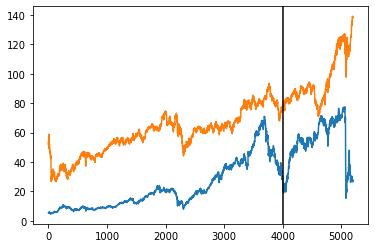

In [ ]:
#plot the selected assets
plt.figure()
for i in range(z):
  plt.plot(asset_list[i])
plt.axvline(x=4000, color='black')

#Utility Functions to Slice Tensors

In [ ]:
def get_slice_array1(i):
  temp = np.tile(np.arange(i+1), z)
  return temp+np.repeat(np.arange(z),i+1)*8

def get_slice_array2():
  temp = np.tile(np.arange(1,9), z)
  return temp+np.repeat(np.arange(z),8)*10

def get_slice_array3():
  temp = np.tile(np.arange(1,10), z)
  return temp+np.repeat(np.arange(z),9)*10

In [ ]:
get_slice_array1(1)

array([0, 1, 8, 9])

In [ ]:
get_slice_array2()

array([ 1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17, 18])

In [ ]:
get_slice_array3()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18,
       19])

#Penalty function $\beta(x)=\max(x,0)^2$

In [ ]:
def beta(x):
    return torch.pow(F.relu(x),0.5)

##Generates the  random sets $A_i = (a_1^{(i)},b_1^{(i)}]\times \dots \times (a_1^{(i)},b_1^{(i)}] \subseteq [\underline{K}^1,\bar{K}^1] \times \dots \times [\underline{K}^d,\bar{K}^d]$, used in Pseudo-Algorithm 1 and Algorithm 3 of the paper. 

In [ ]:
def get_random_partition(stock_mins, stock_maxs, num_sets, discrete = True):
  """
  generate random partitions according to given lower and upper bounds
  according to our algorithm, we only specify "discrete = False"
  """
  partition = np.zeros((num_sets, 2*z))
  stocks_len = (stock_maxs-stock_mins)/grids
  for k in range(num_sets):
    if discrete:
      lower = np.random.randint(0, grids, size=z)
      gap = np.random.randint(1, grids-lower+1, size=z)
      partition[k,:] = np.repeat(stock_mins,2)
      partition[k,::2] += lower*stocks_len
      partition[k,1::2] += (lower+gap)*stocks_len
    else:
      lower = np.random.uniform(low = stock_mins, high = stock_maxs)
      upper = stock_maxs
      partition[k,::2] = lower
      partition[k,1::2] = upper
  return partition

##Algorithm 3 in the Paper

In [ ]:
def get_indicator_matrix(partition, S_n):
  """
  Algorithm 3 in the paper
  Calculate indicators according to terminal prices and the generated partitions
  """
  B = partition.shape[0]
  indicator_matrix = np.zeros((len(S_n), 2**B))
  for i in range(len(S_n)):
    temp = np.ones(B, dtype=bool)
    for j in range(z):
      temp = temp&(partition[:,2*j]<S_n[i,j])
    temp = temp.flatten()
    temp = temp.astype(int)
    pos = int(np.array2string(temp, formatter={'int':lambda x: bin(x)})[1:-1].replace(' ','')[2::3],2)
    indicator_matrix[i][pos]=1
  return torch.FloatTensor(indicator_matrix)


#Evaluates the part of the loss-function inside $\beta$, corresponding to the approximated conditional expectations under the perturbed measures. 

In [ ]:
def get_frac_vector(P_tau_tilde, indicator_matrix):
    #get input data for neural network
    net_input = P_tau_tilde[:,get_slice_array2()]
    #perform forward propagation to obtain deltas for each asset
    delta_list, c = net(net_input)
    h_value_trans = 0
    h_value_pnl = 0
    #calculate the loss function summation
    for i in range(z):
      delta = delta_list[i]
      h_value_trans += trans_cost * torch.abs(torch.cat((delta[:,:1], delta[:,1:]-delta[:,:-1], delta[:,-1:]), 1)).sum(axis = 1)
      h_value_pnl += ((P_tau_tilde[:,10*i+1:10*i+10]-P_tau_tilde[:,10*i:10*i+9])*delta).sum(axis = 1)
    h_value = -c + h_value_trans - h_value_pnl
    temp = torch.matmul(indicator_matrix.T, h_value)
    indicator_sum = torch.sum(indicator_matrix.T, dim=1)
    indicator_sum = torch.where(indicator_sum.abs() > 0.5, indicator_sum, torch.ones((), device = indicator_sum.device, dtype = indicator_sum.dtype))
    return temp/indicator_sum

#Testing and evaluation functions

##Evaluate statistical arbitrage strategy

In [ ]:
def stat_arb_success(stock_test, net):

    f = 0
    gain_list = []
    cost_list = []
    success = []
    
    for i in range(int(len(stock_test[0])/10)):
        
        query_data = np.zeros((1, 8*z))

        for j in range(z):
          query_data[0,8*j:8*(j+1)] = (100*stock_test[j][10*i+1:10*i+9]/stock_test[j][10*i]).reshape(1,-1)

        upper_bound = net(torch.FloatTensor(query_data).cuda())[0]
        upper_bound_list = [delta.detach().cpu().numpy()[0] for delta in upper_bound]

        gain = 0
        cost = 0
        for k in range(z):

          delta = upper_bound_list[k]
          gain += np.dot(delta, stock_test[k][10*i+1:10*i+10]-stock_test[k][10*i:10*i+9])
          cost += trans_cost * np.abs(np.concatenate([np.array([delta[0]]), delta[1:]-delta[:-1], np.array([delta[-1]])])).sum()

        success.append(gain-cost)
        gain_list.append(gain)
        cost_list.append(cost)

        f+=success[-1]
    
    print("Total Gain:", np.array(gain_list).mean(), "Total Cost:", np.array(cost_list).mean())
    success = np.array(success)
    res = dict()
    res['Gain'] = f
    res['Best'] = round(max(success),2)
    res['Worst'] = round(min(success),2)
    res['Average'] = round(success.mean(),2)
    res['loss_perc'] = round(100*float(np.sum(success<0)/len(success)),2)
    res['gains_perc'] = round(100*float(np.sum(success>0)/len(success)),2)
    res['sharp_ratio'] = round(np.sqrt(252.0/9)*success.mean()/success.std(),3)
    res['sortino_ratio'] = round(np.sqrt(252.0/9)*success.mean()/success[success<0].std(),3)
    return res

##Evaluate Buy and Hold strategy

In [ ]:
def stat_arb_success_buy_and_hold(stock_test):

    f = 0
    gain_list = []
    cost_list = []
    success = []
    
    for i in range(int(len(stock_test[0])/10)):

        gain = 0
        cost = 0

        for k in range(z):

          delta = 10*np.ones(9)
          gain += np.dot(delta, stock_test[k][10*i+1:10*i+10]-stock_test[k][10*i:10*i+9])
          cost += trans_cost * np.abs(np.concatenate([np.array([delta[0]]), delta[1:]-delta[:-1], np.array([delta[-1]])])).sum()
        
        success.append(gain-cost)
        gain_list.append(gain)
        cost_list.append(cost)

        f+=success[-1]
    
    print("Total Gain:", np.array(gain_list).mean(), "Total Cost:", np.array(cost_list).mean())
    success = np.array(success)
    res = dict()
    res['Gain'] = f
    res['Best'] = round(max(success),2)
    res['Worst'] = round(min(success),2)
    res['Average'] = round(success.mean(),2)
    res['loss_perc'] = round(100*float(np.sum(success<0)/len(success)),2)
    res['gains_perc'] = round(100*float(np.sum(success>0)/len(success)),2)
    res['sharp_ratio'] = round(np.sqrt(252.0/9)*success.mean()/success.std(),3)
    res['sortino_ratio'] = round(np.sqrt(252.0/9)*success.mean()/success[success<0].std(),3)
    return res


# Evaluate Drawdowns

In [ ]:
def drawdowns(stock_test):
  #define set of trailing window sizes
  trailing_window  = 200

  f = 0
    gain_list = []
    cost_list = []
    success = []
    
    for i in range(int(len(stock_test[0])/10)):
        
        query_data = np.zeros((1, 8*z))

        for j in range(z):
          query_data[0,8*j:8*(j+1)] = (100*stock_test[j][10*i+1:10*i+9]/stock_test[j][10*i]).reshape(1,-1)

        upper_bound = net(torch.FloatTensor(query_data).cuda())[0]
        upper_bound_list = [delta.detach().cpu().numpy()[0] for delta in upper_bound]

        gain = 0
        cost = 0
        for k in range(z):

          delta = upper_bound_list[k]
          gain += np.dot(delta, stock_test[k][10*i+1:10*i+10]-stock_test[k][10*i:10*i+9])
          cost += trans_cost * np.abs(np.concatenate([np.array([delta[0]]), delta[1:]-delta[:-1], np.array([delta[-1]])])).sum()

        success.append(gain-cost)
        gain_list.append(gain)
        cost_list.append(cost)

        f+=success[-1]

  roll_max = stock_test['close']


#Neural Network Class

In [ ]:
class Net_independent(nn.Module):


  def __init__(self, M, z):
      super(Net_independent, self).__init__()
      self.first_layers = nn.ModuleList([nn.Linear(z*i,32*z) for i in range(1,8+1)])
      self.bn_layers = nn.ModuleList([nn.BatchNorm1d(z*i) for i in range(1,8+1)])
      self.second_layers = nn.ModuleList([nn.Linear(32*z,64*z) for i in range(1,8+1)])
      self.third_layers = nn.ModuleList([nn.Linear(64*z,128*z) for i in range(1,8+1)])
      self.fourth_layers = nn.ModuleList([nn.Linear(128*z,z) for i in range(1,8+1)])
      self.c = nn.Parameter(torch.FloatTensor([0]))
      self.delta0_s = nn.Parameter(torch.FloatTensor([0]*z))
      self.M = M

  def forward(self, x):
      output1 = [F.relu(self.first_layers[i](self.bn_layers[i](x[:,get_slice_array1(i)]))) for i in range(8)]
      output2 = [F.relu(self.second_layers[i](output1[i])) for i in range(8)]
      output3 = [F.relu(self.third_layers[i](output2[i])) for i in range(8)]
      deltas = [M*torch.tanh(self.fourth_layers[i](output3[i])) for i in range(8)]
      delta_list = [torch.cat([delta[:,i:i+1] for delta in deltas], axis=1) for i in range(z)]
      return [torch.cat((self.delta0_s[i]*torch.ones((x.shape[0],1)).cuda(),delta_list[i]), axis=1) for i in range(z)], self.c



#Train-Test Split

In [ ]:
stock_train = [asset[:test_begin_day] for asset in asset_list]
stock_test = [asset[test_begin_day:test_end_day] for asset in asset_list]

N = len(stock_train[0])
n=10-1


In [ ]:
print(stock_train)

[array([ 5.43085718,  5.36245823,  5.4171772 , ..., 28.60000038,
       29.09000015, 30.28000069]), array([53.59375   , 52.5625    , 51.5625    , ..., 75.81999969,
       75.97000122, 76.44999695])]


#Physical Measure

In [ ]:
P_hat = np.zeros((z*(n+1),N-n))

for j in range(z):
  for i in range(n+1):
    P_hat[i+j*(n+1),:] = stock_train[j][i:N-n+i]

P_hat = torch.FloatTensor(P_hat.T)


In [ ]:
print(P_hat)
print(P_hat.shape)

tensor([[ 5.4309,  5.3625,  5.4172,  ..., 58.5000, 57.5000, 58.5000],
        [ 5.3625,  5.4172,  5.4172,  ..., 57.5000, 58.5000, 58.4688],
        [ 5.4172,  5.4172,  5.6224,  ..., 58.5000, 58.4688, 57.6875],
        ...,
        [30.8000, 30.7800, 29.5000,  ..., 75.9000, 76.2200, 75.8200],
        [30.7800, 29.5000, 28.2200,  ..., 76.2200, 75.8200, 75.9700],
        [29.5000, 28.2200, 28.4900,  ..., 75.8200, 75.9700, 76.4500]])
torch.Size([3991, 20])


#Calculate lower and upper bounds $\underline{K}^j$ and $\overline{K}^j$ (see Remark 3.2)

In [ ]:
S_lower = torch.FloatTensor([100]*z)
S_upper = torch.FloatTensor([-100]*z)
for i in range(z):
  for j in range(1,n+1):
    S_lower[i] = torch.min(S_lower[i], torch.min(P_hat[:,10*i+j]/P_hat[:,10*i]))
    S_upper[i] = torch.max(S_upper[i], torch.max(P_hat[:,10*i+j]/P_hat[:,10*i]))

rescaled_lower_bounds = S_lower*100 - z
rescaled_upper_bounds = S_upper*100 + z

print(rescaled_lower_bounds, rescaled_upper_bounds)


tensor([65.3547, 58.7774]) tensor([136.8727, 124.4670])


#Initialize numerical experiment

In [ ]:
results = {'Average':[], 'Best':[], 'Worst':[], 'loss_perc':[], 'gains_perc':[], 'sharp_ratio':[], 'sortino_ratio':[]}


#hyperparameters
num_epochs = 100
N_measures = 5
grids = 4
K = 1
trials = 50
epsilon = z
M = 10
trans_cost = 0.0001 #proportional Transaction cost
pnl = []


#Run numerical experiment

Trial: 0
Test at Epoch 0
Total Gain: -7.232230212005869 Total Cost: 0.014028001257578533
{'Gain': -869.5509855916139, 'Best': 142.18, 'Worst': -308.52, 'Average': -7.25, 'loss_perc': 54.17, 'gains_perc': 45.83, 'sharp_ratio': -0.827, 'sortino_ratio': -0.895}
Test at Epoch 10
Total Gain: -0.2758387006546744 Total Cost: 0.0011519768116871516
{'Gain': -33.23888129596339, 'Best': 18.16, 'Worst': -19.88, 'Average': -0.28, 'loss_perc': 51.67, 'gains_perc': 48.33, 'sharp_ratio': -0.424, 'sortino_ratio': -0.477}
Test at Epoch 20
Total Gain: 0.050582232612670544 Total Cost: 0.0011544653842846554
{'Gain': 5.931332067406311, 'Best': 37.18, 'Worst': -10.66, 'Average': 0.05, 'loss_perc': 51.67, 'gains_perc': 48.33, 'sharp_ratio': 0.062, 'sortino_ratio': 0.123}
Test at Epoch 30
Total Gain: 0.19341244362322463 Total Cost: 0.0011402806315819424
{'Gain': 23.072659558997128, 'Best': 48.97, 'Worst': -10.53, 'Average': 0.19, 'loss_perc': 51.67, 'gains_perc': 48.33, 'sharp_ratio': 0.195, 'sortino_ratio': 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Total Gain: -0.5842422834071915 Total Cost: 0.014726726640065512
{'Gain': -71.87628120567078, 'Best': 383.66, 'Worst': -139.64, 'Average': -0.6, 'loss_perc': 52.5, 'gains_perc': 47.5, 'sharp_ratio': -0.061, 'sortino_ratio': -0.117}
Test at Epoch 10
Total Gain: 0.22182111156350803 Total Cost: 0.000863385986785094
{'Gain': 26.514927069206756, 'Best': 41.97, 'Worst': -13.38, 'Average': 0.22, 'loss_perc': 47.5, 'gains_perc': 52.5, 'sharp_ratio': 0.265, 'sortino_ratio': 0.542}
Test at Epoch 20
Total Gain: 0.18878792520185916 Total Cost: 0.0008221738703052204
{'Gain': 22.555890159786475, 'Best': 21.7, 'Worst': -11.36, 'Average': 0.19, 'loss_perc': 42.5, 'gains_perc': 57.5, 'sharp_ratio': 0.349, 'sortino_ratio': 0.49}
Test at Epoch 30
Total Gain: 0.2541582107104209 Total Cost: 0.0008218397958079974
{'Gain': 30.40036450975354, 'Best': 34.73, 'Worst': -12.76, 'Average': 0.25, 'loss_perc': 45.0, 'gains_perc': 55.0, 'sharp_ratio': 0.345, 'sortino_ratio': 0.6}
Test at Epoch 40
Total Gain: 0.164497

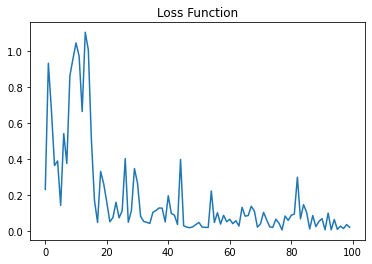

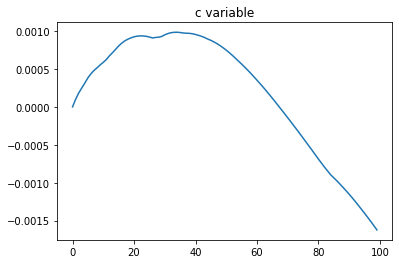

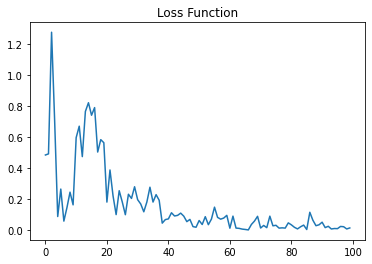

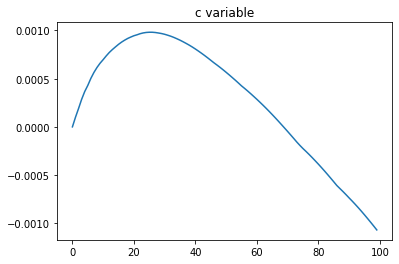

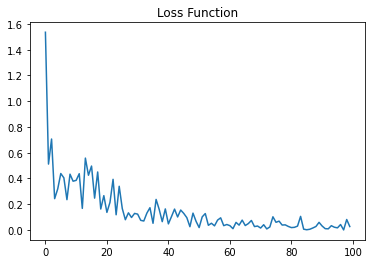

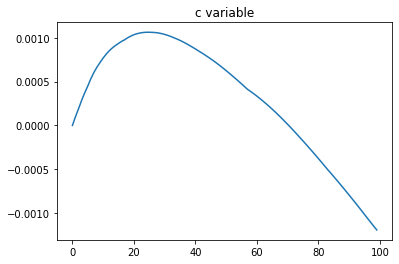

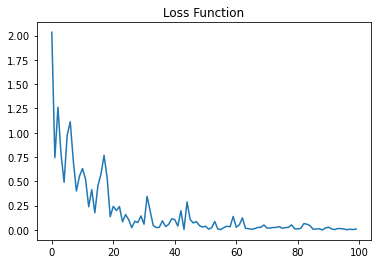

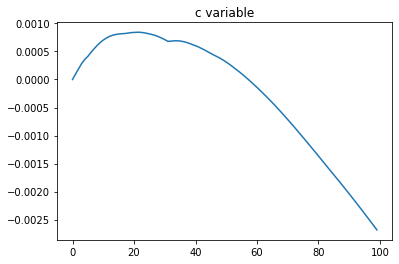

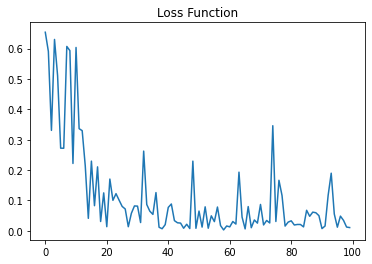

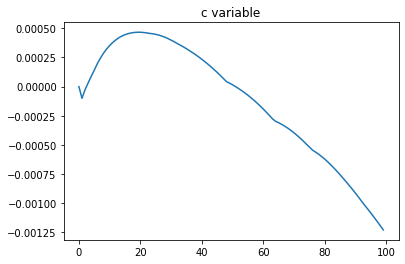

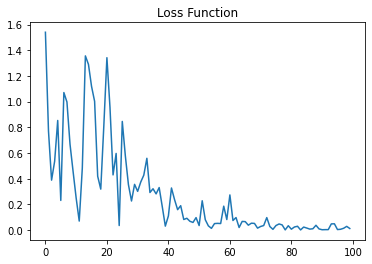

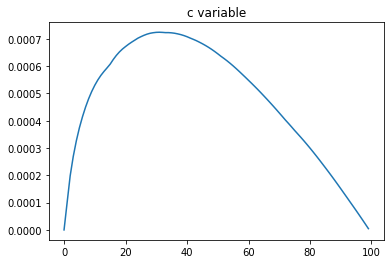

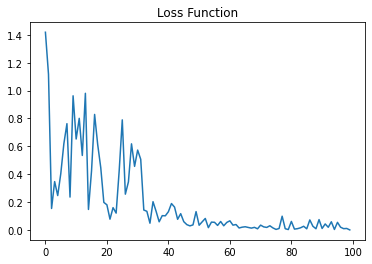

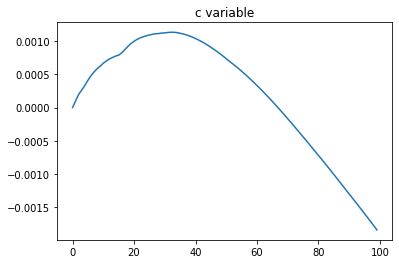

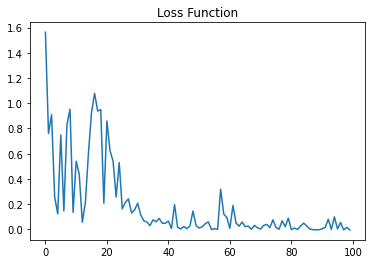

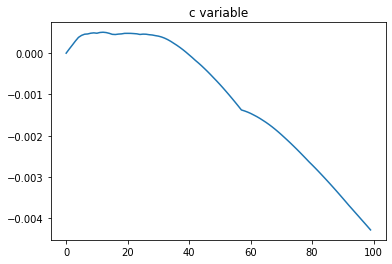

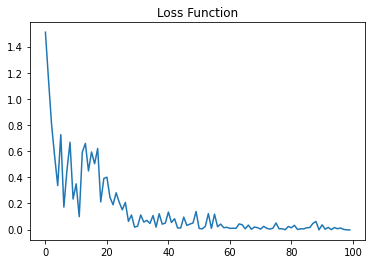

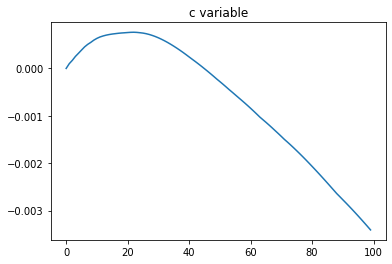

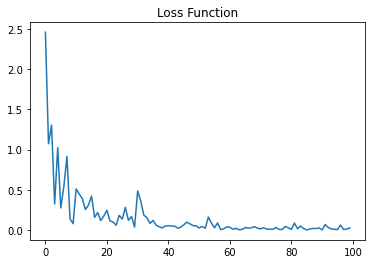

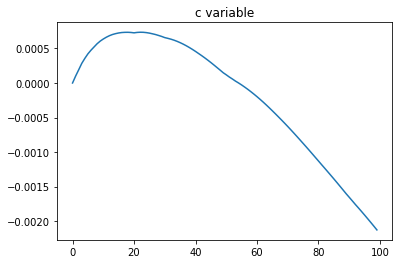

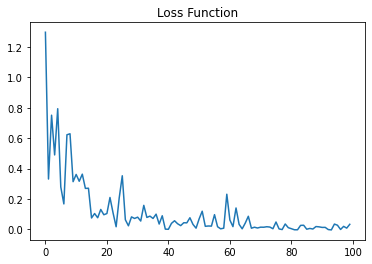

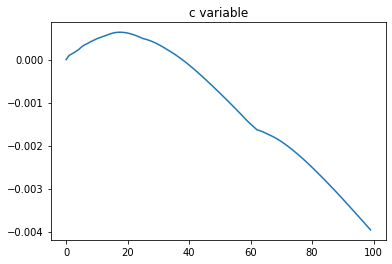

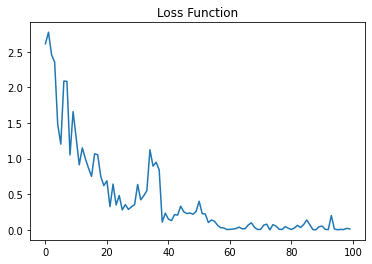

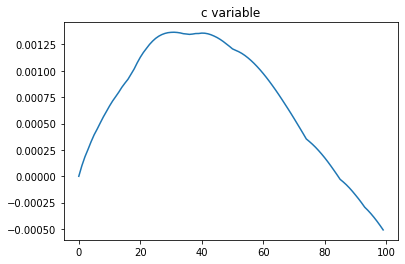

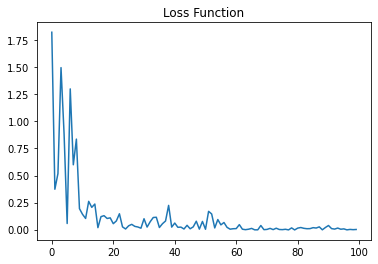

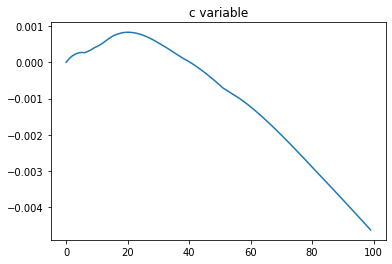

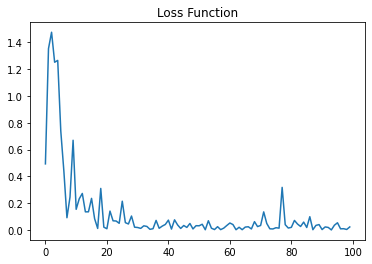

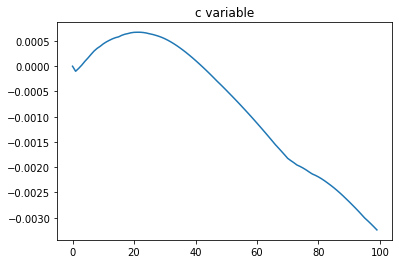

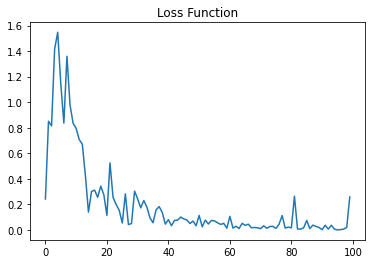

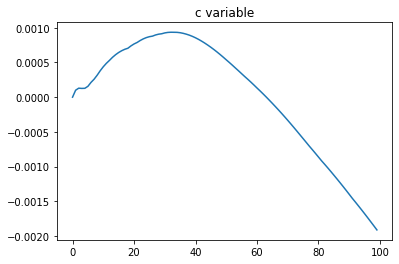

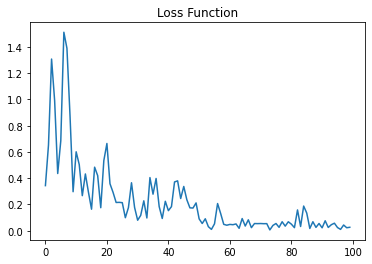

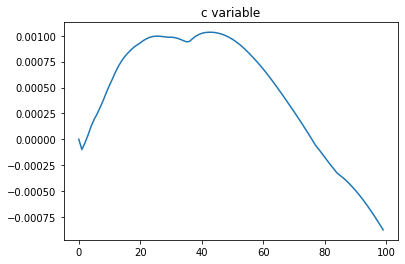

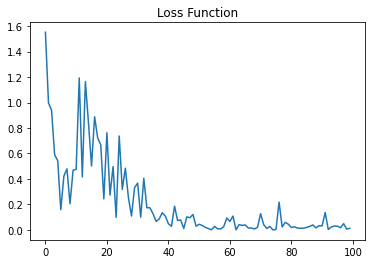

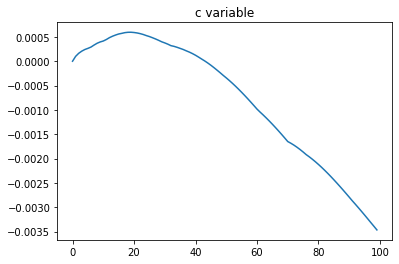

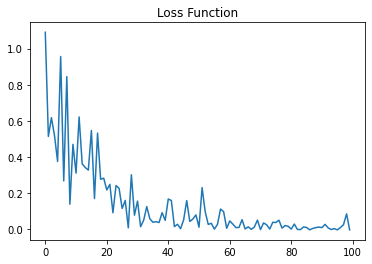

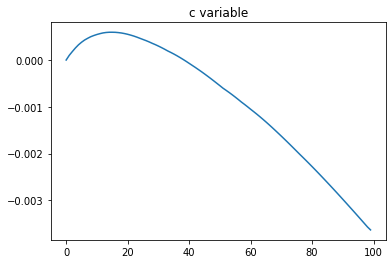

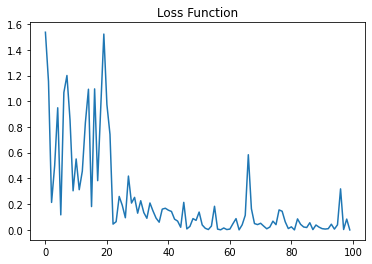

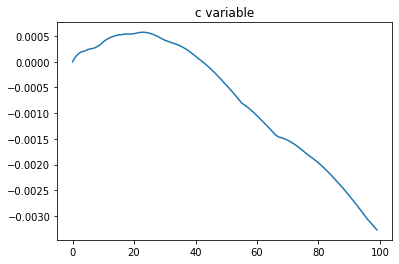

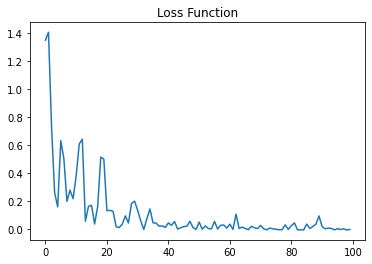

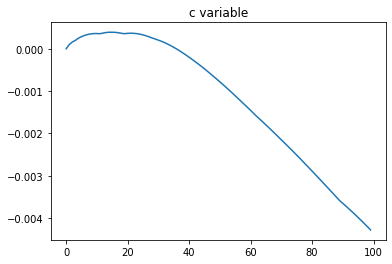

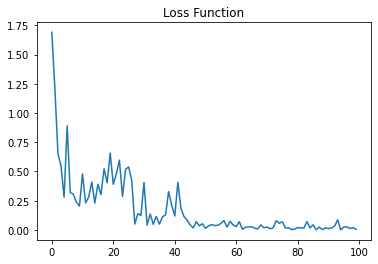

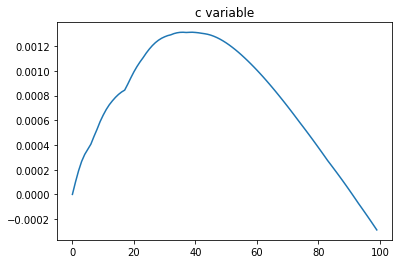

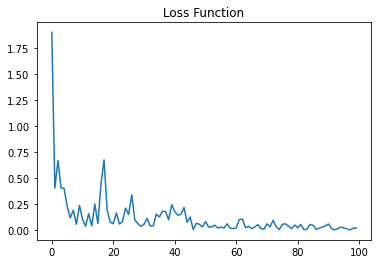

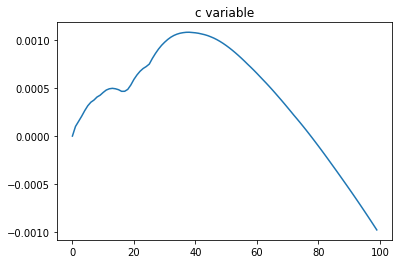

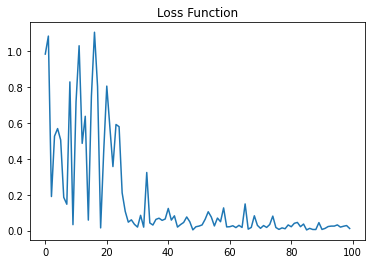

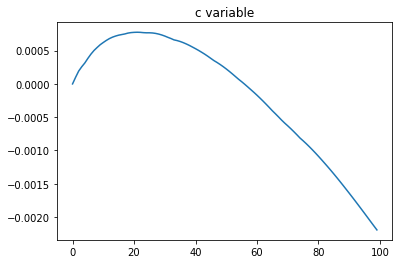

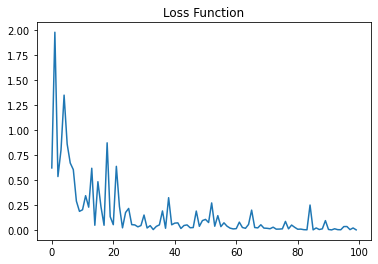

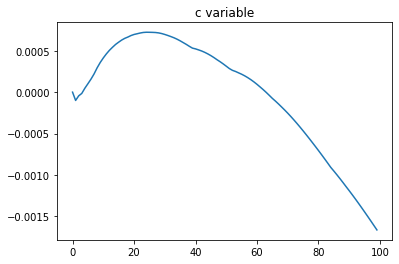

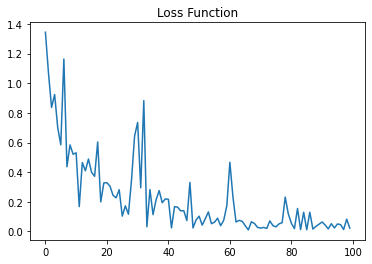

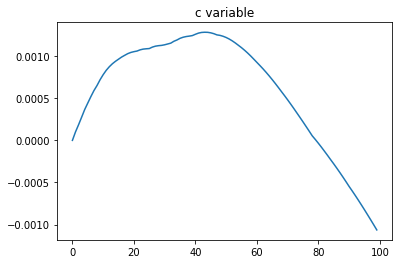

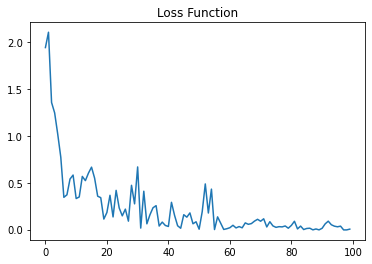

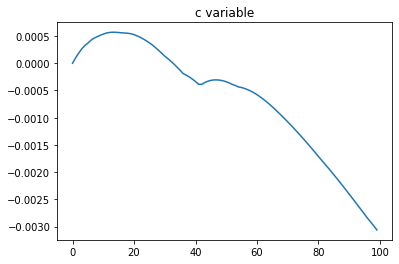

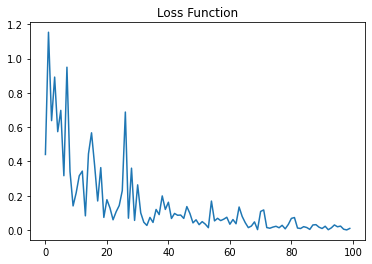

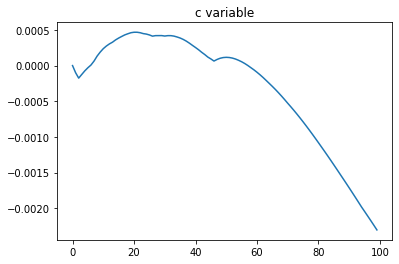

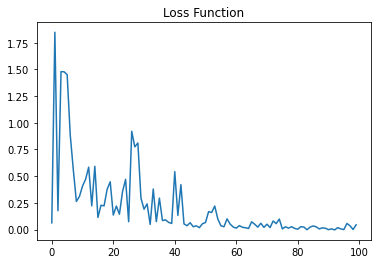

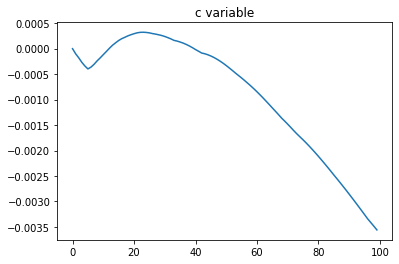

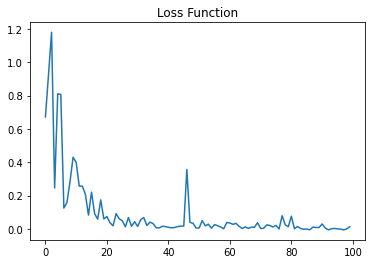

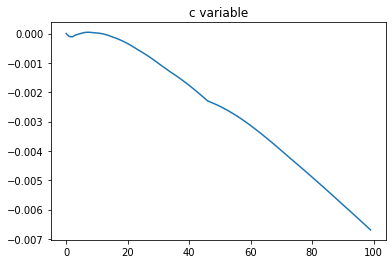

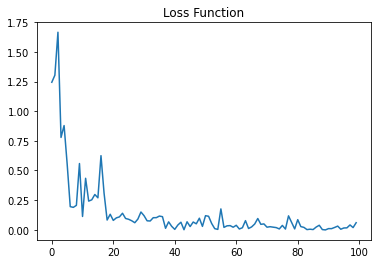

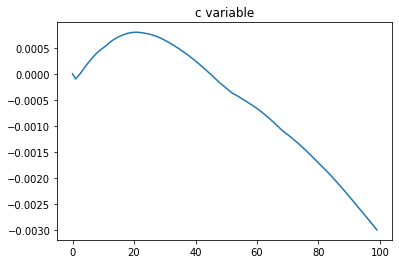

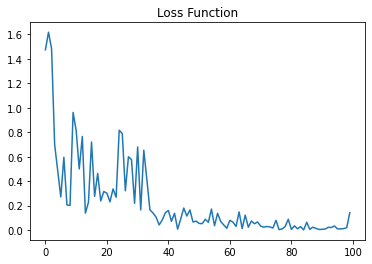

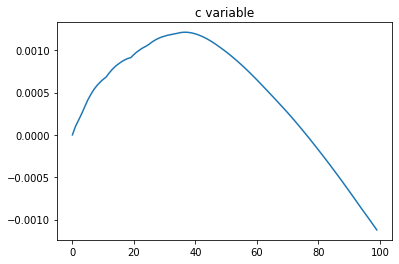

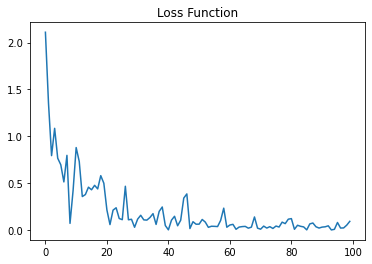

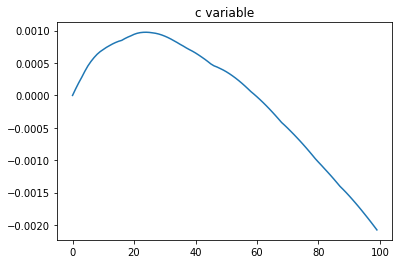

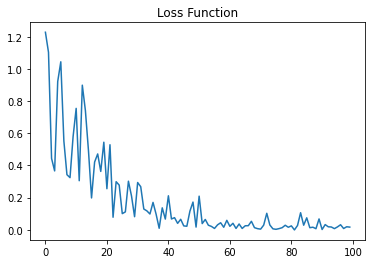

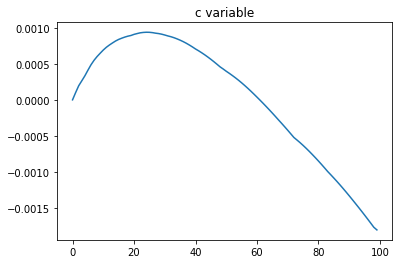

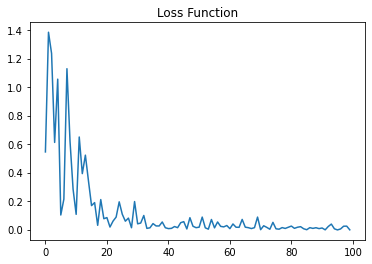

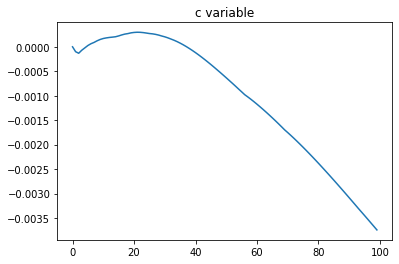

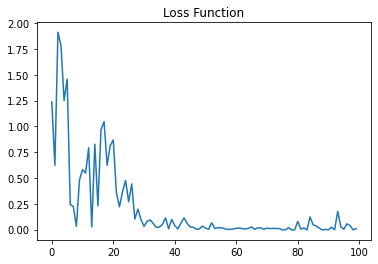

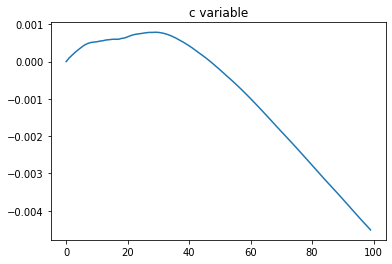

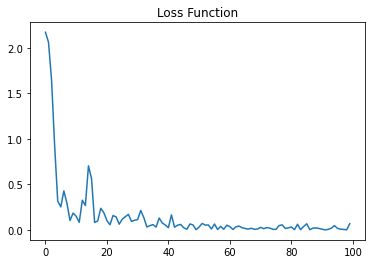

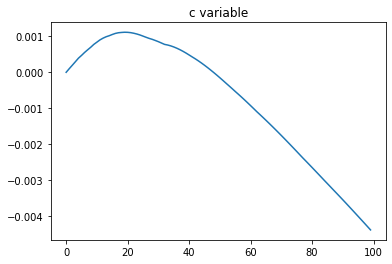

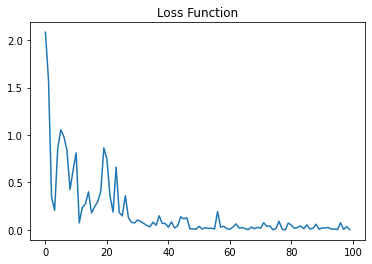

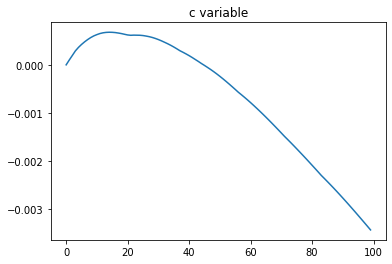

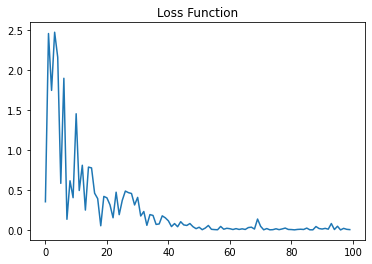

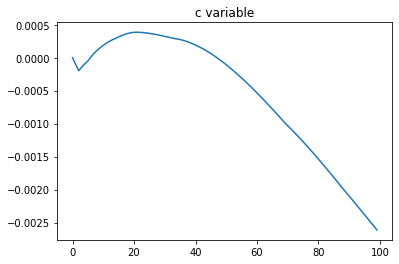

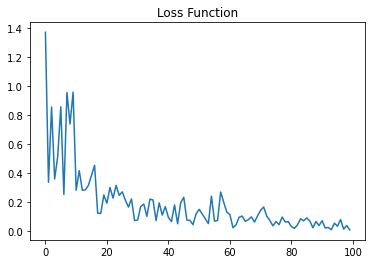

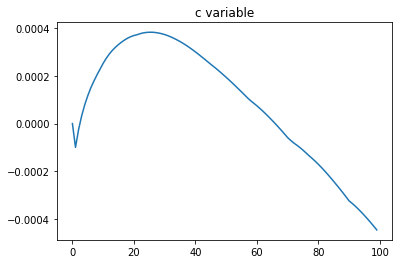

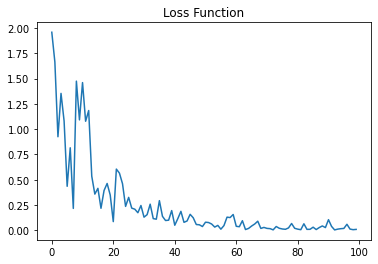

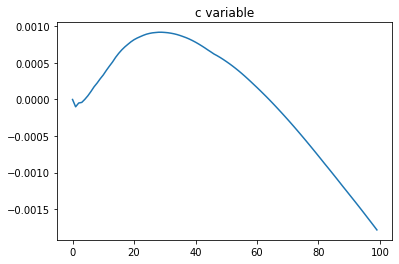

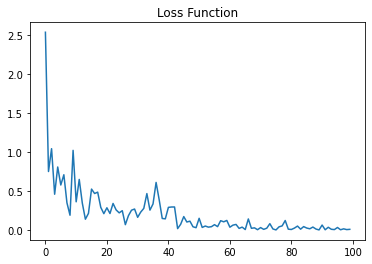

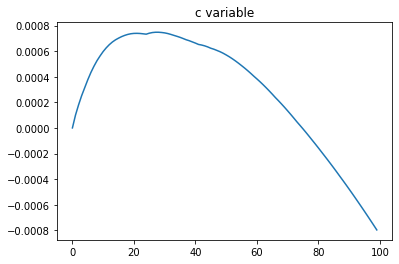

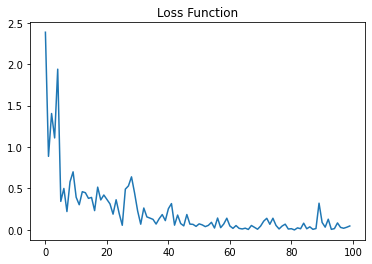

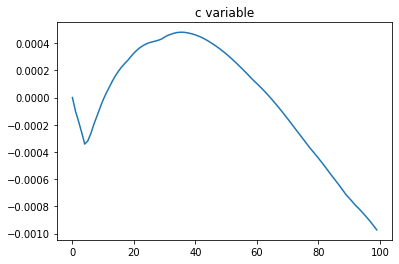

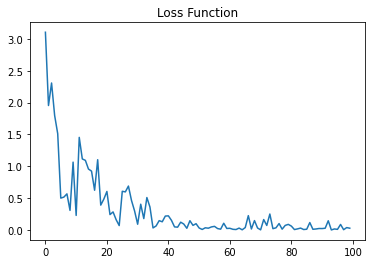

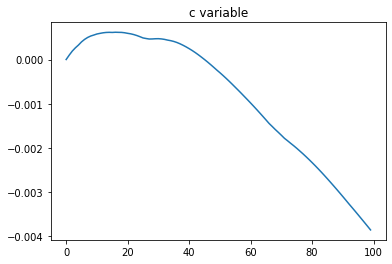

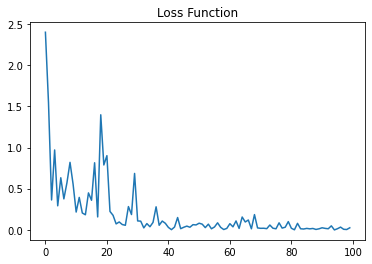

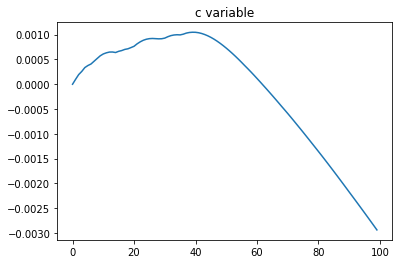

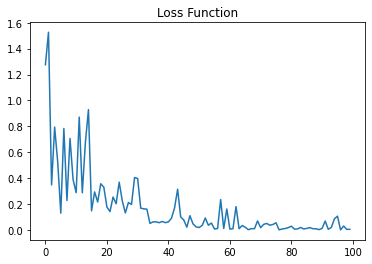

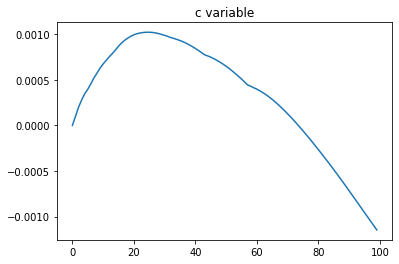

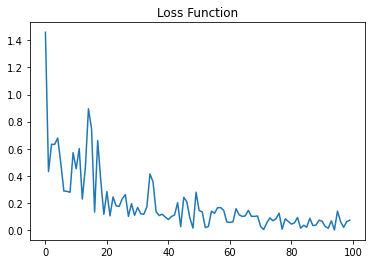

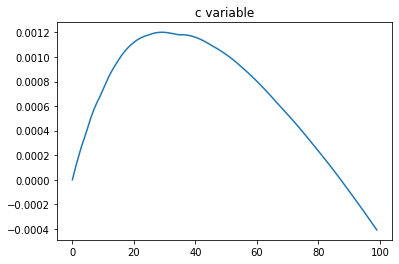

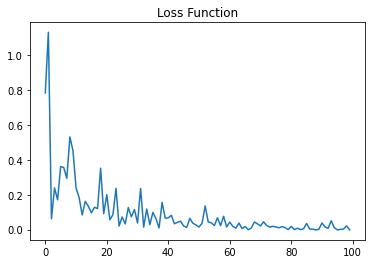

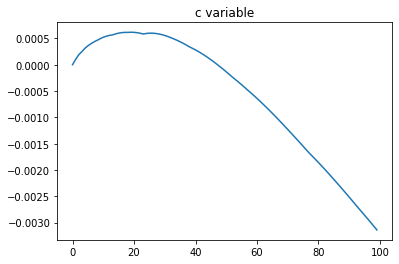

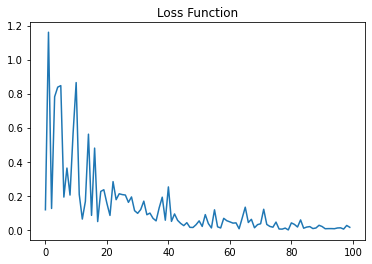

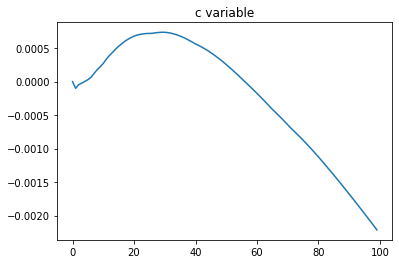

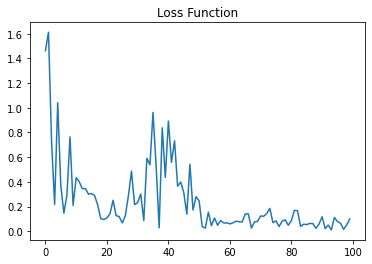

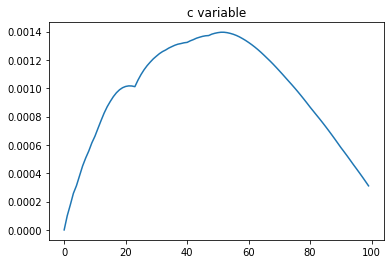

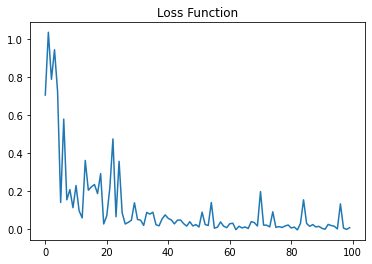

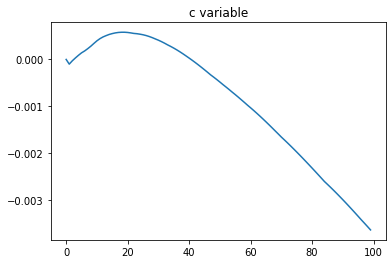

In [ ]:
for trial in range(trials):
  np.random.seed(trial)
  torch.manual_seed(trial)
  print("Trial:", trial)
  net = Net_independent(M,z).cuda()
  net.train()
  optimizer = optim.Adam(net.parameters(), lr=1e-4)
  loss_rec = []
  c_rec = []
  for epoch in range(num_epochs):

      if epoch%10==0:
        print("Test at Epoch", epoch)
        net.eval()
        record = stat_arb_success(stock_test, net)
        net.train()
        print(record)

      optimizer.zero_grad()
      total_loss = 0
      partition = get_random_partition(rescaled_lower_bounds, rescaled_upper_bounds, 12, False)
      
      for m in range(N_measures):
          
          batch_index = np.arange(P_hat.shape[0])
          P_tau_tilde = P_hat.clone()

          #normalization
          for j in range(z):
            P_tau_tilde[:,10*j:10*(j+1)] /= (P_tau_tilde[:,10*j]/100).reshape(-1,1)
          
          #Algorithm 2 in the paper
          #generate perturbation
          tau_m = torch.FloatTensor(np.random.normal(0,1,(P_hat.shape[0], P_hat.shape[1]-z)))
          U_epsilon = torch.FloatTensor(epsilon * np.random.rand(1))
          tau_tilde = U_epsilon * tau_m/torch.norm(tau_m, p=2, dim=1, keepdim=True)

          #3991x10d Matrix containig perturbed stock paths as rows
          P_tau_tilde[:,get_slice_array3()] += tau_tilde

          #Final Stock prices of all paths
          S_n = P_tau_tilde[:,np.arange(1,z+1)*10-1].numpy()
          S_n = S_n[batch_index]
          
          indicator_matrix = get_indicator_matrix(partition, S_n).cuda()
          P_tau_tilde = P_tau_tilde.cuda()
          P_tau_tilde = P_tau_tilde[batch_index]

          frac_vector = get_frac_vector(P_tau_tilde, indicator_matrix)
          total_loss += beta(torch.matmul(indicator_matrix, frac_vector)).sum()/len(S_n)
      
      #target loss function accroding to Algorithm 4 in the paper
      total_loss = net.c + K * total_loss
      loss_rec.append(total_loss.item())
      c_rec.append(net.c.clone().detach().cpu().numpy()[0])
      total_loss.backward()
      optimizer.step()
      #clip the values between -M and M
      with torch.no_grad():
        net.c.clamp_(-M, M)
        net.delta0_s.clamp_(-M, M)

  print("Done Training")
  net.eval()
  record = stat_arb_success(stock_test, net)
  print("Result After Training:")
  print(record)

  pnl.append(record)

  plt.figure()
  plt.plot(loss_rec)
  plt.title('Loss Function')
  plt.savefig("loss.eps", format = 'eps')

  plt.figure()
  plt.plot(c_rec)
  plt.title('c variable')
  plt.savefig("c.png")

#Report Results

Overall Profit: 49.54
Average Profit: 0.41
gains_perc: 52.45
Best: 47.38
Worst: -16.44
sharp_ratio: 0.3757
sortino_ratio: 1.4488


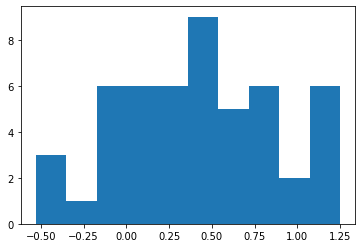

In [ ]:
with open('pnl.json', 'w') as f:
    json.dump(pnl, f)

plt.hist([p['Average'] for p in pnl])

print("Overall Profit:", np.round(np.mean([result['Gain'] for result in pnl]),2))
print("Average Profit:", np.round(np.mean([result['Average'] for result in pnl]),2))
print("gains_perc:", np.round(np.mean([result['gains_perc'] for result in pnl]),2))
print("Best:", np.round(np.mean([result['Best'] for result in pnl]),2))
print("Worst:", np.round(np.mean([result['Worst'] for result in pnl]),2))
print("sharp_ratio:", np.round(np.mean([result['sharp_ratio'] for result in pnl]),4))
print("sortino_ratio:", np.round(np.mean([result['sortino_ratio'] for result in pnl]),4))